# PROJET 5 : Catégorisez automatiquement les questions 

**PLAN DE PROJET**
1. Titre de projet : PROJET 5 - Catégorisez automatiquement les questions


2. Chargement de bibliothèques


3. Récupérer les données + Séparation de données en test et train
    - Enregistrement de fichiers en .csv :
        - X_train.csv
        - y_train.csv
        - X_test.csv
        - y_test.csv


4. Data cleaning
    - Features :
        - Enlever les balises HTML
        - Enlever la ponctuation
        - Mise en minuscule et tokenization
        - Enlever les stopwords
    - Target :
        - Enlever les balises "<>"


5. Feature engineering 
    - Recodage en bigrams
    - Fusion de title, body + bigrams


6. Analyse exploratoire
    - Analyses univariées
        - Description générale : Longueur de posts, nombre de tags
        - Bag of words : Les expressions les plus fréquentes : feature & target
            - Arrays générées:
                - X_train_bow
                - X_train_vocab_bow
                - X_train_dist_bow
                - y_train_bow
                - y_train_vocab_bow
                - y_train_dist_bow
                
                
        - TF - IDF : Les expressions les plus fréquentes : feature & target
             - Arrays générées:
                  - X_train_ifidf
                  - X_train_vocab_ifidf
                  - X_train_dist_ifidf
                  - y_train_ifidf
                  - y_train_vocab_ifidf
                  - y_train_dist_ifidf
                  

    - Analyse multivarié 
    **QUESTION : Peut-on considérer LDA comme analyse multivariée ?**
    
    
    - Réduction de dimensions
    **QUESTION : Peut-on faire un word2vec ?**
    
    
        

# Chargement de bibliothéques

In [2]:
# Import the libraries
import joblib
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.decomposition import PCA

import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
import re

# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup 

# Libraries for data visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [4]:
#Disable warning for .loc
pd.options.mode.chained_assignment = None  # default='warn'

# Récupération de données

Les données était récupérées de stack overflow à l'aide de code suivant :

SELECT body, title, tags FROM posts 
WHERE title is not null and body is not null and tags is not null and FavoriteCount>20


In [5]:
data_load = pd.read_csv(
    'Data/data_best_rating.csv', sep=',')

In [6]:
data_load.shape

(50000, 3)

In [7]:
data_load.head()

,body,title,tags
0,<p>Is there a way to compile and run a C progr...,How do I run a C program from VIM?,<c><vim>
1,<p>I've been using Eclipse with RDT (not RadRa...,What Ruby IDE do you prefer?,<ruby><ide><editor>
2,<p>We are developing an application that invol...,How to generate sample XML documents from thei...,<xml><xsd><dtd><test-data>
3,<p>I know that IList is the interface and List...,When to use IList and when to use List,<c#><.net>
4,<p>Word wrap is one of the must-have features ...,Best word wrap algorithm?,<algorithm><word-wrap>


Exemple de la première question:

In [8]:
print (data_load['body'][2])

<p>We are developing an application that involves a substantial amount of XML transformations. We do not have any proper input test data per se, only DTD or XSD files. We'd like to generate our test data ourselves from these files. Is there an easy/free way to do that?</p>

<p><strong>Edit</strong></p>

<p>There are apparently no free tools for this, and I agree that OxygenXML is one of the best tools for this.</p>



## Création d'un jeu de données test

Notre variable cible est la variable tags. Nous avons deux variables texte qui nous permettrons estimer le tag : variables title et body. Nous allons séparer 30 % de données qui seront utilisées plus tard afin de tester les modèles :

In [9]:
target = data_load['tags']

In [10]:
data=data_load.drop(['tags'], axis=1)

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target, test_size=0.3, random_state=1)

In [12]:
print ("Le jeu de données X_train contient", X_train.shape[0], "observations et", X_train.shape[1], "features.") 
print ("Le vecteur y_train contient", y_train.shape[0], "observations.") 
print ("Le jeu de données X_test contient", X_test.shape[0], "observations et", X_test.shape[1], "features.") 
print ("Le vecteur y_test contient", y_test.shape[0], "observations.")  

Le jeu de données X_train contient 35000 observations et 2 features.
Le vecteur y_train contient 35000 observations.
Le jeu de données X_test contient 15000 observations et 2 features.
Le vecteur y_test contient 15000 observations.


Exporter les jeux de données en .csv

In [13]:
X_train.to_csv('Data/X_train.csv', sep='\t')
X_test.to_csv('Data/X_test.csv', sep='\t')
y_train.to_csv('Data/y_train.csv', sep='\t', header=False)
y_test.to_csv('Data/y_test.csv', sep='\t', header=False)

# Data cleaning 

## Tester les fonctions sur un exemple de features

### Enlever les balises html

Pour enlever les balises HTML, nous allons utiliser le package BeautifulSoup:

In [19]:
# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(X_train['body'][1])  

# Print the raw review and then the output of get_text(), for 
# comparison
print (X_train['body'][1])
print (example1.get_text())

<p>I've been using Eclipse with RDT (not RadRails) a lot lately, and I'm quite happy with it, but I'm wondering if you guys know any decent alternatives. I know NetBeans also supports Ruby these days, but I'm not sure what it has to offer over Eclipse.</p>

<p>Please, list any features you think are brilliant or useful when suggesting an IDE, makes it easier to compare.</p>

<p>Also, I said Ruby, not Rails. While Rails support is a plus, I prefer things to be none Rails-centric. It should also be available on Linux and optionally Solaris.</p>

I've been using Eclipse with RDT (not RadRails) a lot lately, and I'm quite happy with it, but I'm wondering if you guys know any decent alternatives. I know NetBeans also supports Ruby these days, but I'm not sure what it has to offer over Eclipse.
Please, list any features you think are brilliant or useful when suggesting an IDE, makes it easier to compare.
Also, I said Ruby, not Rails. While Rails support is a plus, I prefer things to be none 

### Enlever la ponctuation

Nous allons enlever la ponctuation tout en gardant les nombres, lettres ainsi que les signes "-", "+" et "#" étant donné que ces signes sont souvent utilisés dans l'informatique. 

In [20]:
letters_only = re.sub("[^0-9#+a-zA-Z]",       # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text() )  # The text to search
print (letters_only)

I ve been using Eclipse with RDT  not RadRails  a lot lately  and I m quite happy with it  but I m wondering if you guys know any decent alternatives  I know NetBeans also supports Ruby these days  but I m not sure what it has to offer over Eclipse  Please  list any features you think are brilliant or useful when suggesting an IDE  makes it easier to compare  Also  I said Ruby  not Rails  While Rails support is a plus  I prefer things to be none Rails centric  It should also be available on Linux and optionally Solaris  


### Mise en minuscule et tokenization

In [22]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()               # Split into words

### Stopwords

In [23]:
# Let's have a look to the stopwords from ntlk.corpus
print (stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print (words)

['using', 'eclipse', 'rdt', 'radrails', 'lot', 'lately', 'quite', 'happy', 'wondering', 'guys', 'know', 'decent', 'alternatives', 'know', 'netbeans', 'also', 'supports', 'ruby', 'days', 'sure', 'offer', 'eclipse', 'please', 'list', 'features', 'think', 'brilliant', 'useful', 'suggesting', 'ide', 'makes', 'easier', 'compare', 'also', 'said', 'ruby', 'rails', 'rails', 'support', 'plus', 'prefer', 'things', 'none', 'rails', 'centric', 'also', 'available', 'linux', 'optionally', 'solaris']


### Lemmatisation

In [26]:
lemmatizer = WordNetLemmatizer() 

lems = []

for word in words:
    word = lemmatizer.lemmatize(word)
    lems.append(word)
    
print(lems)

NameError: name 'words' is not defined

## Tester les fonctions sur un exemple de targets

Les tags (notre variable cible) ont une forme spécifiques. Les mots sont entre "<>". Les tags sont parfois composés par deux, voir plusieurs mots qui sont séparés par "-". Nous allons enlever les balises.

In [35]:
#Take the first tag from the dataset
tag = y_train[0]

In [36]:
#Check
tag

'<c><vim>'

In [37]:
#Remove first '<'
tag = tag[1:]

In [38]:
#Check
tag

'c><vim>'

In [39]:
#Remove last '>'
tag = tag[:-1]

In [40]:
#Check
tag

'c><vim'

In [41]:
#Remove remaining '><' signs
tag = tag.split('><')

In [42]:
#Check
tag

['c', 'vim']

In [43]:
#Converting back to string
tag_clean = " ".join(tag)  

In [44]:
#Check
tag_clean

'c vim'

## Pipelines pour data cleaning

### Features

Nous allons utiliser la fonction suivante pour automatiser le processus de data cleaning :

In [79]:
def post_to_words( raw_post ):
    """Function to convert a raw document to a string of words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove HTML
    post_text = BeautifulSoup(raw_post).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^0-9#-+a-zA-Z]", " ", post_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in meaningful_words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
    #
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( lems )) 

In [80]:
X_train['body_clean']=X_train['body'].apply(lambda x: post_to_words(x))

In [81]:
X_train['title_clean']=X_train['title'].apply(lambda x: post_to_words(x))

In [82]:
X_train.head()

,body,title,text,body_clean,title_clean
8950,<p>Vi and Vim allow for really awesome customi...,What is in your .vimrc?,What is in your .vimrc?. <p>Vi and Vim allow f...,vi vim allow really awesome customization typi...,vimrc
38421,"<p>This might sound lame, but I have not been...",LINQ Aggregate algorithm explained,LINQ Aggregate algorithm explained. <p>This mi...,might sound lame able find really good explana...,linq aggregate algorithm explained
19363,<p>Is it possible to read a .PST file using C#...,Can I read an Outlook (2003/2007) PST file in C#?,Can I read an Outlook (2003/2007) PST file in ...,possible read pst file using c# would like sta...,read outlook (2003 2007) pst file c#
30157,<p>I want to be able to output the current loo...,How to output loop.counter in python jinja tem...,How to output loop.counter in python jinja tem...,want able output current loop iteration templa...,output loop counter python jinja template
14294,<p>Context: I'm working on master adding a sim...,Git: Create a branch from unstaged/uncommitted...,Git: Create a branch from unstaged/uncommitted...,context i'm working master adding simple featu...,git create branch unstaged uncommitted change ...


Nous allons aussi construire une fonction qui nous servira comme paramètre de tokenizer personnalisé que nous allons appliquer dans l'outil CountVectorizer, afin de garder la structure de bigrams que l'on a créé pendant la transformation de features. Nous allons séparer les mot tout simplement en utilisant méthode .split() qui sépare les mots par espace et laisse les caractères spéciaux comme par exemple '#' collé sur les mots, contrairement à la méthode .tokenize() 

In [83]:
def my_tokenizer(doc):
    
    """Function defining personalized tokenizer for sklearn's CountVectorizer in order to keep the created 
    bigrams in tag's format.
    
    Input:
    
    - doc : string to be tokenized
    
    Output:
    
    - tokenized string
    """
    
    
    tokens = doc.split()
    
    return tokens

Nous allons définir les stop-words que nous n'avons pas enlevé dans l'étape de cleaning, mais qui figurent souvent dans les posts et qui n'ont pas de valeur informative. La liste sera également utilée en paramètre de CountVectorizer et TfidfVectorizer.

In [84]:
stop_words = ["i'm", 'would', '1', '0', '2', "i've", 'could', 'anyone', 'also', '3', 'thanks', 
               'two', 'however', "i'd", '5', "+", "#", "im", "ive", "dont", "cant", "id", ")", "("]

### Target

In [85]:
def cleaning_target(raw_target):
    """Function to remove '<>' signs from target list and to replace them with a space
    
    Arguments :
    - raw_target : a Series of tags
    
    Return :
    - Series with cleaned tags
       
    """
    
    #Remove first '<'
    tag = raw_target[1:]
    
    #Remove last '>'
    tag = tag[:-1]
    
    #Remove remaining '><' signs
    tag = tag.split('><')
    
    #Converting back to string
    tag_clean = " ".join(tag)  
    
    return tag_clean

In [86]:
y_train_clean=y_train.apply(lambda x: cleaning_target(x))

In [87]:
y_train_clean.head()

8950                              vim refactoring
38421                                c# .net linq
19363    c# outlook outlook-2007 outlook-2003 pst
30157                               python jinja2
14294                               git git-stash
Name: tags, dtype: object

# Feature engineering

## Créer les bigrams

Nous allons créer des bigrams, car les tags sont souvent composés par deux mots, séparés par "-". Les bigrams créé à partir de text de body et title vont donc être mis au même format que les tags.

### Tester les fonctions sur un exemple de post

In [88]:
#Take the first element of the cleaned body text
body = X_train['body_clean'][0]

In [89]:
#Split it to a list of words
body = body.split()

In [90]:
#Check
body[:10]

['way',
 'compile',
 'run',
 'c',
 'program',
 'vim',
 'without',
 'typing',
 'filename']

In [91]:
#Creating bigrams object
bigram = nltk.bigrams(body)

In [92]:
#Creating a list of bigram objects
liste = list(bigram)

In [93]:
#Check
liste[:10]

[('way', 'compile'),
 ('compile', 'run'),
 ('run', 'c'),
 ('c', 'program'),
 ('program', 'vim'),
 ('vim', 'without'),
 ('without', 'typing'),
 ('typing', 'filename')]

In [94]:
#Creating a tag-like word from tuples
bigrams_rec = []

for i in range(len(liste)):
    tuple1 = liste[i]
    elt = tuple1[0] + '-' + tuple1[1]
    bigrams_rec.append(elt)

In [95]:
#Creating a string from list of tag-like bigrams
bigrams_str = " ".join(bigrams_rec)

### Créer des pipelines pour le recodage en bigrams

Nous allons utiliser deux fonctions afin de :
    1. créer les bigrams
    2. recoder les bigrams dans le même format comme les tags dans notre variable cible

In [96]:
def create_bigrams(var):
    
    """Function which generates a liste of tuples representing bigrams. 
    
    Arguments :
    - var : feature to be recoded
    
    Returns :
    - a Series of recoded feature  
    
    """
   
   #Take the i-th element of the cleaned body text
    body = var    
        
    #Split it to a list of words
    body = body.split()
    
    #Creating bigrams object
    bigram = nltk.bigrams(body)
    
    #Creating a list of bigram objects 
    liste_bigram = list(bigram)
        
        
    return liste_bigram

In [97]:
X_train['body_bigram'] = X_train['body_clean'].apply(lambda x : create_bigrams(x))

In [98]:
X_train['body_bigram'].head()

8950     [(vi, vim), (vim, allow), (allow, really), (re...
38421    [(might, sound), (sound, lame), (lame, able), ...
19363    [(possible, read), (read, pst), (pst, file), (...
30157    [(want, able), (able, output), (output, curren...
14294    [(context, i'm), (i'm, working), (working, mas...
Name: body_bigram, dtype: object

In [99]:
def recode_bigrams(liste):
    """Function which recode the bigrams generated by recode_bigram function.
    Each bigram has the same structure as the stack overflow tages :
    it is composed of two words and the words are separated by '-'  
    
    Arguments :
    - liste : a liste containing bigram tuples
    
    Return :
    
    - a string of recoded bigrams_rec
    """
    
    #Creating a tag-like word from tuples
    bigrams_rec = []

    for i in range(len(liste)):
        tuple1 = liste[i]
        elt = tuple1[0] + '-' + tuple1[1]
        bigrams_rec.append(elt)
        
    return " ".join(bigrams_rec)

In [100]:
X_train['body_bigram_clean'] = X_train['body_bigram'].apply(lambda x : recode_bigrams(x))

In [101]:
X_train['body_bigram_clean'].head()

8950     vi-vim vim-allow allow-really really-awesome a...
38421    might-sound sound-lame lame-able able-find fin...
19363    possible-read read-pst pst-file file-using usi...
30157    want-able able-output output-current current-l...
14294    context-i'm i'm-working working-master master-...
Name: body_bigram_clean, dtype: object

Nous allons appliquer les mâmes fonctions sur la feature title :

In [102]:
X_train['title_bigram'] = X_train['title_clean'].apply(lambda x : create_bigrams(x))

In [103]:
X_train['title_bigram_clean'] = X_train['title_bigram'].apply(lambda x : recode_bigrams(x))

In [104]:
X_train['title_bigram_clean'].head()

8950                                                      
38421    linq-aggregate aggregate-algorithm algorithm-e...
19363    read-outlook outlook-(2003 (2003-2007) 2007)-p...
30157    output-loop loop-counter counter-python python...
14294    git-create create-branch branch-unstaged unsta...
Name: title_bigram_clean, dtype: object

### Fusionner le title, body et les bigrams

Afin de simplifier le travail exploratiore et les recodages de text qui va être utilisé dans la partie analyse, nous allons créer une feature unique composée par le text de title, de body et des bigrams créés à partir de ces deux features :

In [105]:
X_train['post'] = X_train['title_clean'] + " " + X_train['body_clean'] + " " + X_train['body_bigram_clean'] + " " + X_train['title_bigram_clean']  

In [106]:
X_train['post'].head()

8950     vimrc vi vim allow really awesome customizatio...
38421    linq aggregate algorithm explained might sound...
19363    read outlook (2003 2007) pst file c# possible ...
30157    output loop counter python jinja template want...
14294    git create branch unstaged uncommitted change ...
Name: post, dtype: object

In [107]:
X_train['post'][0]

'run c program vim way compile run c program vim without typing filename way-compile compile-run run-c c-program program-vim vim-without without-typing typing-filename run-c c-program program-vim'

### Bag of words

Nous allons transformer les données text en matrice creuse, appelée Bag-of-Words, qui indique le nombre d'apparitions d'un mot dans la chaîne de caractères. A l'aide de cette transformation, nous allons pouvoir effectuer des opérations numériques sur les chaînes de caractères, notamment calculer des caractéristiques univariées telles que fréquences.  


La matrice représentant Bag-of-Words contient autant de colonnes que le nombre de mots dans le corpus (ensemble de posts dans notre cas). Nous allons utiliser une option max_features = 50 000 qui limite le nombre de features à 50 000.

#### Feature

In [79]:
#First execution
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 50000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_bow = X_train_bow.toarray()

Creating the bag of words...



In [80]:
X_train_bow.shape

(35000, 50000)

In [87]:
# Create a vocabulary of features
X_train_vocab_bow = vectorizer.get_feature_names()

In [88]:
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [84]:
freq_features = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features['Pourcentage'] = round(freq_features['Frequence']*100/sum(freq_features['Frequence']),2)
freq_features[:50]

,Word,Frequence,Pourcentage
18472,file,17905,0.54
46303,using,16342,0.49
26627,like,15817,0.47
45663,use,15068,0.45
20442,get,13553,0.41
11431,code,13308,0.40
48020,way,12581,0.38
10931,class,12308,0.37
6626,android,12172,0.36
47748,want,11313,0.34


Nous constatons que dans les 50 mots les plus courants, nous avons des expressions qui ne nous apporte pas de valeur informative - nous allons donc actualiser la liste de stop words à enlever et réexécuter la transformation en BOW.

In [105]:
#Stop-words update
stop_words += ['using', 'use', 'way', 'want', 'new', 'one', 'work', 'need', 'example', 'know',
               'question', '4', 'line', 'make', '*', 'something', 'find', 'problem', 'following', 
               'create', 'x', 'run', "'", 'trying', 'change', 'used', 'see', 'possible', 'tried', 
               'first', 'without', 'found', 'seems', 'e', 'different', 'b', '8', '10', 'best', 
               'thing', "can't", '6', 'simple', 'answer', '7', 'working', 'good', 'look', 'right', 
               'help', 'another', 'v', 'try', 'point', 'would-like', '0-0', 'default', 'able', 'really', 
               'say', 'looking', 'show', 'idea', 'n', 'even', 'understand', 'better', 'please', 'p',
               'instead', 'think', 'else', 'etc', '$', '9', 'since', 'already', 'give', 'sure']

In [106]:
#Second execution after stop-words update
print ("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 50000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

X_train_bow = vectorizer.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_bow = X_train_bow.toarray()

Creating the bag of words...



In [107]:
# Second execution
X_train_bow.shape

(35000, 50000)

In [108]:
# Second execution
# Create a vocabulary of features
X_train_vocab_bow = vectorizer.get_feature_names()

In [109]:
# Second execution
# Sum up the counts of each vocabulary word
X_train_dist_bow = np.sum(X_train_bow, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [110]:
# Second execution
freq_features = DataFrame(zip(X_train_vocab_bow, X_train_dist_bow))
freq_features.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features['Pourcentage'] = round(freq_features['Frequence']*100/sum(freq_features['Frequence']),2)
freq_features[:50]

,Word,Frequence,Pourcentage
18387,file,17905,0.60
26607,like,15817,0.53
20377,get,13553,0.45
11391,code,13308,0.44
10891,class,12308,0.41
6656,android,12172,0.41
41656,string,10306,0.34
24891,java,9992,0.33
13982,data,9628,0.32
16947,error,9572,0.32


#### Cible

In [112]:
print ("Creating the bag of words...\n")

y_train_bow = vectorizer.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_bow = y_train_bow.toarray()

Creating the bag of words...



In [113]:
y_train_bow.shape

(35000, 9411)

In [115]:
# Creating tag's vocabulary
y_train_vocab_bow = vectorizer.get_feature_names()

In [117]:
freq_target = DataFrame(zip(y_train_vocab_bow, y_train_dist_bow))
freq_target.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target['Pourcentage'] = round(freq_target['Frequence']*100/sum(freq_target['Frequence']),2)
freq_target[:50]

,Word,Frequence,Pourcentage
4367,javascript,3244,2.96
4329,java,3195,2.92
6567,python,3189,2.91
234,android,2542,2.32
1220,c#,2419,2.21
1227,c++,1580,1.44
4219,ios,1368,1.25
4453,jquery,1260,1.15
6166,php,1224,1.12
3339,git,1173,1.07


#### Sauvegarder les données

In [ ]:
np.save('Data/X_train_bow', X_train_bow)
np.save('Data/X_train_vocab_bow', X_train_vocab_bow)
np.save('Data/X_train_dist_bow', X_train_dist_bow)
np.save('Data/y_train_bow', y_train_bow)
np.save('Data/y_train_vocab_bow', y_train_vocab_bow)
np.save('Data/y_train_dist_bow', y_train_dist_bow)

### TF - IDF

#### Feature

In [108]:
print ("Creating the TF - IDF...\n")
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tf_idf = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = my_tokenizer,    \
                             preprocessor = None, \
                             strip_accents=None,
                             max_features = 50000,
                             lowercase=False,
                             stop_words = stop_words)                       
                            

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
X_train_tfidf = tf_idf.fit_transform(X_train['post'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
X_train_tfidf = X_train_tfidf.toarray()

Creating the TF - IDF...



In [109]:
X_train_tfidf.shape

(35000, 50000)

In [110]:
# Take a l vocabulary
X_train_vocab_tfidf = tf_idf.get_feature_names()

In [111]:
# Sum up the counts of each vocabulary word
X_train_dist_tfidf = np.sum(X_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [112]:
freq_features = DataFrame(zip(X_train_vocab_tfidf, X_train_dist_tfidf))
freq_features.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_features.sort_values(['Frequence'], inplace = True, ascending=False)
freq_features['Pourcentage'] = round(freq_features['Frequence']*100/sum(freq_features['Frequence']),2)
freq_features[:50]

,Word,Frequence,Pourcentage
18472,file,603.006290,0.30
45663,use,469.768009,0.23
46303,using,466.642574,0.23
26627,like,459.451247,0.23
48020,way,429.951371,0.21
41630,string,413.904356,0.20
20442,get,408.678822,0.20
11431,code,401.661426,0.20
47748,want,389.756934,0.19
10931,class,382.882799,0.19


#### Cible

In [113]:
print ("Creating the TF - IDF...\n")

y_train_tfidf = tf_idf.fit_transform(y_train_clean)

# Numpy arrays are easy to work with, so convert the result to an 
# array
y_train_tfidf = y_train_tfidf.toarray()

Creating the TF - IDF...



In [114]:
y_train_tfidf.shape

(35000, 9417)

In [115]:
# Create the vocabulary
y_train_vocab_tfidf = tf_idf.get_feature_names()

In [116]:
# Sum up the counts of each vocabulary word
y_train_dist_tfidf = np.sum(y_train_tfidf, axis=0)

Nous allons afficher 50 mots les plus fréquents :

In [117]:
freq_target = DataFrame(zip(y_train_vocab_tfidf, y_train_dist_tfidf))
freq_target.rename({0:'Word', 1:'Frequence'}, axis = 1, inplace = True)
freq_target.sort_values(['Frequence'], inplace = True, ascending=False)
freq_target['Pourcentage'] = round(freq_target['Frequence']*100/sum(freq_target['Frequence']),2)
freq_target[:50]

,Word,Frequence,Pourcentage
4369,javascript,1186.905991,2.02
6571,python,1104.531652,1.88
4331,java,1011.857785,1.73
234,android,896.713176,1.53
1220,c#,808.970977,1.38
4455,jquery,596.178924,1.02
3341,git,596.133409,1.02
1227,c++,576.280258,0.98
6169,php,510.793682,0.87
3819,html,504.519545,0.86


#### Sauvegarder les données

In [133]:
np.save('Data/X_train_tfidf', X_train_tfidf)
np.save('Data/X_train_vocab_tfidf', X_train_vocab_tfidf)
np.save('Data/X_train_dist_tfidf', X_train_dist_tfidf)
np.save('Data/y_train_tfidf', y_train_tfidf)
np.save('Data/y_train_vocab_tfidf', y_train_vocab_tfidf)
np.save('Data/y_train_dist_tfidf', y_train_dist_tfidf)

### Word2vect


Afin de créer un vecteur de ots pour chaque document avec word2vect, nous allons modifier notre fonctions de cleaning. Pour plus d'efficacité de l'algorithme word2vect, nous allons séparer le corps de texte en phrases et garder les stop-words. Nous allons également garder les chiffres et la ponctuation.

#### Préparer les données

In [14]:
X_train_sample = X_train[:100]

Nous allons travailler sur la feature "text" créé par titre + corps de post. Les deux seront séparé par "." afin de distinguer les phrases. 

In [15]:
X_train_sample['text'] = X_train_sample['title'] + ". " + X_train_sample['body']

Voici notre fonction de cleaning modifiée, avec une option pour enlever les stop-words. Par défaut, la fonction n'enlève pas des stop-words.

In [61]:
def post_to_words_w2v( raw_post, remove_stopwords=False ):
    """Function to convert a raw document to a list of words. 
    This cleaning function do not remove the stop words.
    
    Inputs : 
    
    - raw_post : a single string 
    
    Output :
    
    - a single string containing a preprocessed document"""
    
    # 1. Remove HTML
    post_text = BeautifulSoup(raw_post).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", post_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                          
    # 
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Lematize
    lemmatizer = WordNetLemmatizer() 

    lems = []

    for word in words:
        word_clean = lemmatizer.lemmatize(word)
        lems.append(word_clean)
    #
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(words) 

In [62]:
# Personnaliser la fonction
# Download the punkt tokenizer for sentence splitting
#import nltk.data #!!! Supprimer ???
#nltk.download()  #!!! Supprimer ??? 

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def post_to_sentences( post, tokenizer):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(post.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( post_to_words_w2v( raw_sentence ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [63]:
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for post in X_train_sample["text"]:
    sentences += post_to_sentences(post, tokenizer)

Parsing sentences from training set


In [29]:
len(sentences)

515

In [30]:
sentences[0]

['what', 'is', 'in', 'your', 'vimrc']

In [39]:
#Clean all data

X_train['text'] = X_train['title'] + ". " + X_train['body']

sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for post in X_train["text"]:
    sentences += post_to_sentences(post, tokenizer)

Parsing sentences from training set


C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://fbexternal-a.akamaihd.net/safe_image.php?..." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


#### Entraîner le modèle

##### !!! Traduire & faire le tuning de paramètres 

With the list of nicely parsed sentences, we're ready to train the model. There are a number of parameter choices that affect the run time and the quality of the final model that is produced. For details on the algorithms below, see the word2vec API documentation as well as the Google documentation. 

    Architecture: Architecture options are skip-gram (default) or continuous bag of words. We found that skip-gram was very slightly slower but produced better results.
    Training algorithm: Hierarchical softmax (default) or negative sampling. For us, the default worked well.
    Downsampling of frequent words: The Google documentation recommends values between .00001 and .001. For us, values closer 0.001 seemed to improve the accuracy of the final model.
    Word vector dimensionality: More features result in longer runtimes, and often, but not always, result in better models. Reasonable values can be in the tens to hundreds; we used 300.
    Context / window size: How many words of context should the training algorithm take into account? 10 seems to work well for hierarchical softmax (more is better, up to a point).
    Worker threads: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.
    Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. In this case, since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles. This resulted in an overall vocabulary size of around 15,000 words. Higher values also help limit run time.

Choosing parameters is not easy, but once we have chosen our parameters, creating a Word2Vec model is straightforward:

In [40]:
# The model is trained on the sample
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2019-11-08 11:31:21,817 : INFO : collecting all words and their counts
2019-11-08 11:31:21,817 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-08 11:31:21,864 : INFO : PROGRESS: at sentence #10000, processed 247018 words, keeping 13760 word types
2019-11-08 11:31:21,895 : INFO : PROGRESS: at sentence #20000, processed 486456 words, keeping 20137 word types
2019-11-08 11:31:21,957 : INFO : PROGRESS: at sentence #30000, processed 729331 words, keeping 25621 word types


Training model...


2019-11-08 11:31:22,004 : INFO : PROGRESS: at sentence #40000, processed 967744 words, keeping 30037 word types
2019-11-08 11:31:22,051 : INFO : PROGRESS: at sentence #50000, processed 1210663 words, keeping 34290 word types
2019-11-08 11:31:22,098 : INFO : PROGRESS: at sentence #60000, processed 1450666 words, keeping 38068 word types
2019-11-08 11:31:22,145 : INFO : PROGRESS: at sentence #70000, processed 1694684 words, keeping 41914 word types
2019-11-08 11:31:22,191 : INFO : PROGRESS: at sentence #80000, processed 1935338 words, keeping 45999 word types
2019-11-08 11:31:22,254 : INFO : PROGRESS: at sentence #90000, processed 2170522 words, keeping 49270 word types
2019-11-08 11:31:22,301 : INFO : PROGRESS: at sentence #100000, processed 2407298 words, keeping 52615 word types
2019-11-08 11:31:22,347 : INFO : PROGRESS: at sentence #110000, processed 2647479 words, keeping 55913 word types
2019-11-08 11:31:22,394 : INFO : PROGRESS: at sentence #120000, processed 2893893 words, keepin

Le vocabulaire de mots est stocké dans l'attribute model.vocabulary :

In [76]:
print (model.vocabulary)

In [74]:
#!!! Comment utiliser le vocabulaire ??? 
"python" in (model.vocabulary)

TypeError: 'Word2VecVocab' object is not iterable

#### Tester le modèle

Nous allons tester la méthode doesnt_match qui va rechercher un mot qui est différent des autres dans une chaîne de caractères donné.

In [42]:
model.doesnt_match("html css div sql windows".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'windows'

In [43]:
model.doesnt_match("python javascript jupyter anaconda".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'javascript'

In [47]:
model.doesnt_match("git github fetch browser commit".split())

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
C:\Users\Utilisateur\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'browser'

La méthode similar va sortir une liste de mots qui sont les plus proche de l'expression indiquée :

In [44]:
model.most_similar("python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('py', 0.5671464204788208),
 ('packages', 0.5633114576339722),
 ('virtualenv', 0.5545641183853149),
 ('pip', 0.5461310148239136),
 ('pypi', 0.5093796253204346),
 ('ipython', 0.5084605813026428),
 ('anaconda', 0.5061459541320801),
 ('perl', 0.500555157661438),
 ('scrapy', 0.48912513256073),
 ('django', 0.48505112528800964)]

In [45]:
model.most_similar("html")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('xhtml', 0.698453426361084),
 ('doctype', 0.6541997194290161),
 ('erb', 0.6508492231369019),
 ('body', 0.6398696899414062),
 ('stylesheet', 0.5964100956916809),
 ('actionlink', 0.5836066007614136),
 ('markup', 0.5810596942901611),
 ('innerhtml', 0.5763190388679504),
 ('render', 0.5545802116394043),
 ('htm', 0.5516344308853149)]

In [46]:
model.most_similar("server")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('client', 0.6742444634437561),
 ('servers', 0.5771112442016602),
 ('iis', 0.5537930727005005),
 ('redis', 0.5482082366943359),
 ('localhost', 0.5434677600860596),
 ('smtp', 0.5308704376220703),
 ('port', 0.5235759615898132),
 ('dns', 0.519524097442627),
 ('nginx', 0.5170530080795288),
 ('connects', 0.5103957653045654)]

Nous pouvons aussi étudier la similarité entre deux mots :

In [48]:
model.similarity(w1="python", w2="python")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [49]:
model.similarity(w1="python", w2="jupyter")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.43874839509055036

In [50]:
model.similarity(w1="python", w2="windows")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.18953097742208663

In [51]:
model.similarity(w1="windows", w2="linux")

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.6779998903760502

#### Représentation numérique de mots

In [55]:
type(model.syn0_lockf)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [53]:
#Number of words in the model
model.syn0_lockf.shape

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0_lockf` (Attribute will be removed in 4.0.0, use self.trainables.vectors_lockf instead).
  """Entry point for launching an IPython kernel.


(5537,)

In [58]:
#Length of the word vector = num_features (attribute of w2v function) 
len(model.wv["python"])

300

In [60]:
#Exemple of the word vector
model.wv["python"][:10]

array([-0.00783841, -0.00125786,  0.00396897,  0.01340571, -0.04914111,
        0.05074711,  0.08276056, -0.04706008, -0.03149038, -0.04971832],
      dtype=float32)

In [78]:
# Comment faire ???
"python" in model.vocabulary

AttributeError: 'Word2VecKeyedVectors' object has no attribute 'vocabulary'

#### Préparer les vecteurs de mots pour la modélisation

###### !!! Tutorial Kaggle : comprendre la méthode et ré-expliquer 
One challenge with the IMDB dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review (for this purpose, we removed stop words, which would just add noise).

In [67]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(posts, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0.
    # 
    # Preallocate a 2D numpy array, for speed
    postFeatureVecs = np.zeros((len(posts),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for post in posts:
       #
       # Print a status message every 1000th review
        if counter%1000. == 0.:
            print ("Post %d of %d" % (counter, len(posts)))
       # 
       # Call the function (defined above) that makes average feature vectors
        postFeatureVecs[counter] = makeFeatureVec(post, model, \
           num_features)
       #
       # Increment the counter
        counter = counter + 1.
    return postFeatureVecs

In [ ]:
model.wv.index2word

In [68]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.

clean_train_posts = []
for post in X_train["text"]:
    clean_train_posts.append( post_to_words_w2v( post, \
        remove_stopwords=True ))

trainDataVecs = getAvgFeatureVecs( clean_train_posts, model, num_features )

#print "Creating average feature vecs for test review"
#clean_test_posts = []
#for post in test["post"]:
#    clean_test_posts.append( post_to_wordlist( post, \
#        remove_stopwords=True ))

#testDataVecs = getAvgFeatureVecs( clean_test_posts, model, num_features )

Post 0 of 35000


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Analyse exploratoire

## Description générale

Nous allons tout d'abord étudier la longueur de notre chaîne de caractère de post, ainsi que le nombre de tags attribué à chaque post :

In [73]:
nbr_mots = X_train['post'].apply(lambda row : len(row.split()))

In [74]:
nbr_mots.describe()

count    35000.000000
mean       162.536257
std        239.274600
min          2.000000
25%         60.000000
50%        104.000000
75%        184.000000
max       8678.000000
Name: post, dtype: float64

Feature post, qui contient le titre, le corps de post et les bigrams créés à partir de titre et le corps de post, contient en moyen 163 mots. Le minimum est 2 mots et le maximum 8678 mots.


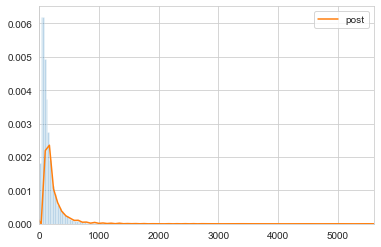

In [75]:
#!!! Améliorer le graphique pour la présentation
plt.hist(nbr_mots, alpha=0.3, range=(
    0, 5600),  bins=200, density=True)
sns.kdeplot(nbr_mots)

plt.xlim(0, 5600)
plt.rcParams['figure.figsize'] = (20, 20)

In [76]:
y_train_clean.head()

8950                              vim refactoring
38421                                c# .net linq
19363    c# outlook outlook-2007 outlook-2003 pst
30157                               python jinja2
14294                               git git-stash
Name: tags, dtype: object

In [77]:
nbr_tags = y_train_clean.apply(lambda row : len(row.split()))

In [78]:
nbr_tags.describe()

count    35000.000000
mean         3.133686
std          1.182454
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: tags, dtype: float64

Le nombre de tags varie de 1 à 6 avec la valeurs médiane de 3 tags par post.

## Fréquences des expressions

### Bag of words

Nous allons afficher les fréquences de 50 features les plus utilisées :

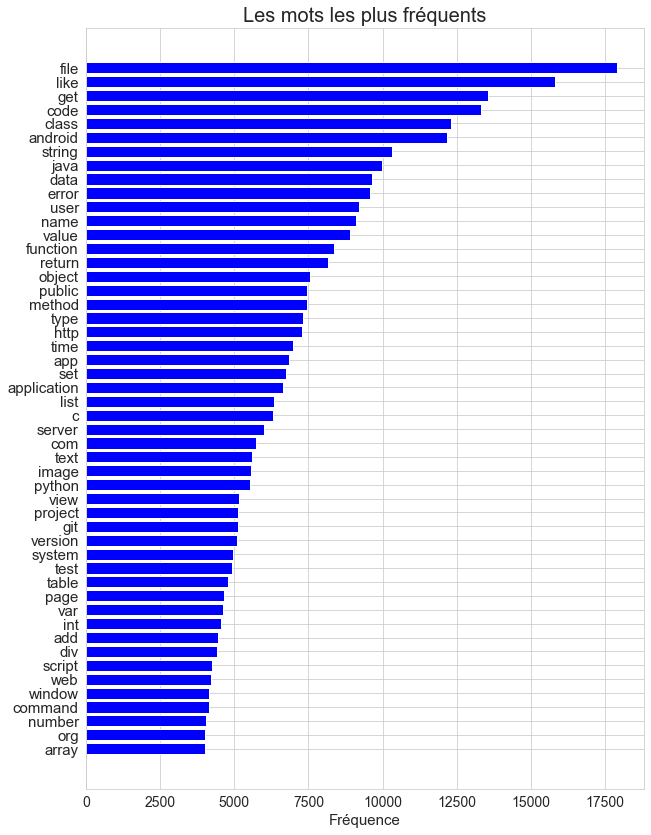

In [111]:
freq_features_50 = freq_features[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

Faisons le même affichage pour les tags.

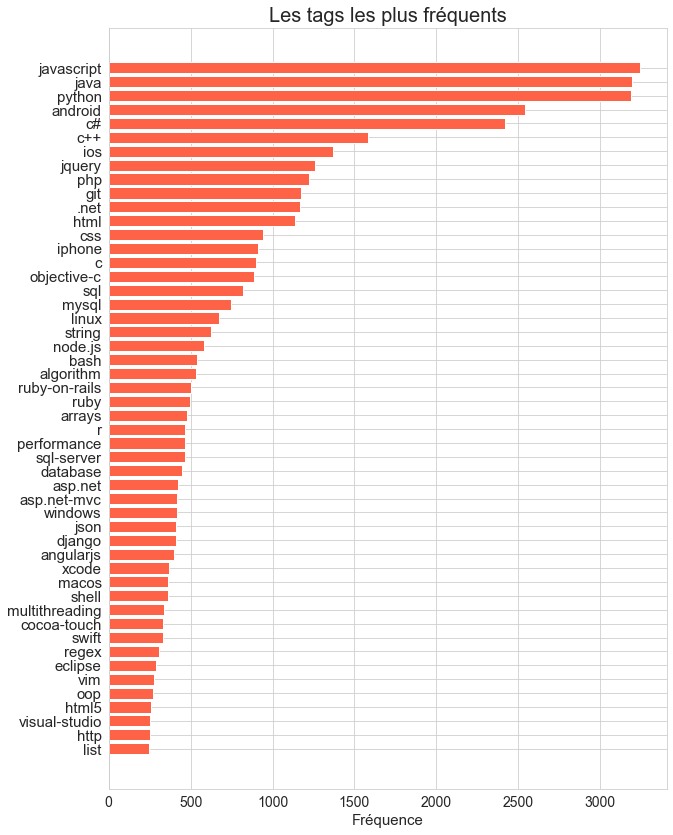

In [118]:
freq_target_50 = freq_target[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='tomato', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

### TF-IDF

Pour pouvoir faire comparaison, nous allons aussi afficher les mot les plus fréquentes en se basant sur les fréquences relatives TF-IDF :

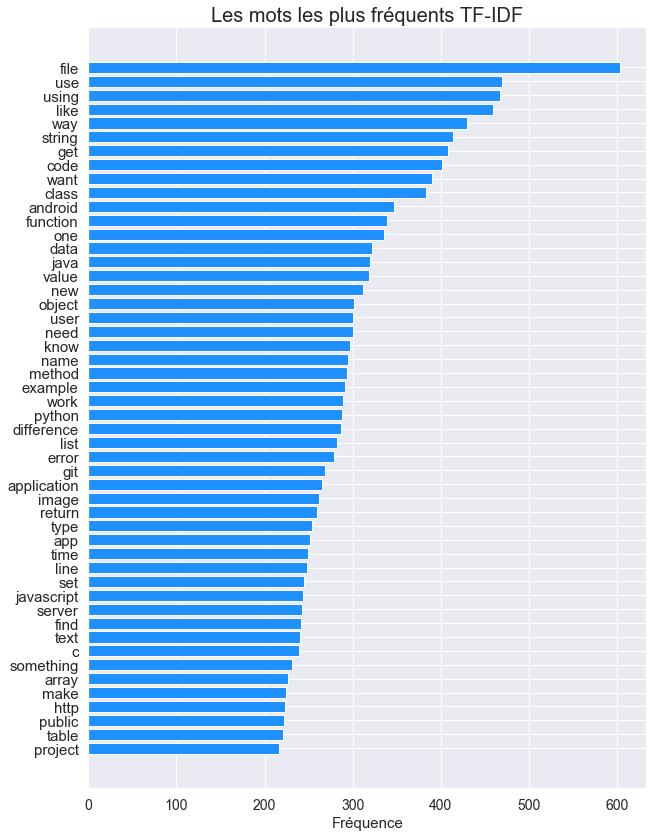

In [132]:
freq_features_50 = freq_features[:50]
freq_features_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les mots les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_features_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='dodgerblue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_features_50['Word'], fontsize=15)

# Show graphic
plt.show()

Affichons également un graphique de tags :

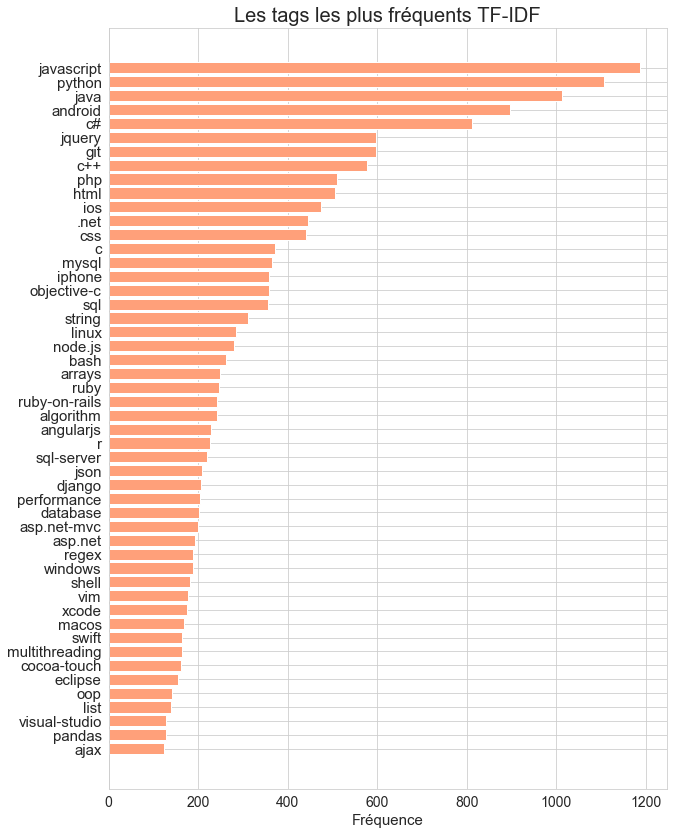

In [132]:
freq_target_50 = freq_target[:50]
freq_target_50.sort_values(by=['Frequence'], ascending=True, inplace = True)

fig = plt.figure(figsize=(10, 14))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Fréquence', fontsize=15)
ax.set_title('Les tags les plus fréquents TF-IDF', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = freq_target_50['Frequence']

# Make the plot
plt.barh(range(50), bars1, color='lightsalmon', edgecolor='white')

# Add xticks on the middle of the group bars
plt.yticks(
    range(50), freq_target_50['Word'], fontsize=15)

# Show graphic
plt.show()

Nous constatons seulement légères différences par rapport à la méthode bag of words.

## Réduction de dimension

### Analyse en composantes principales

Nous allons effectuer une analyse en composante principales afin de visualiser les données. L'ACP va être performé sur les données transformées par TF-IDF.

#### All features

In [120]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_tfidf)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])

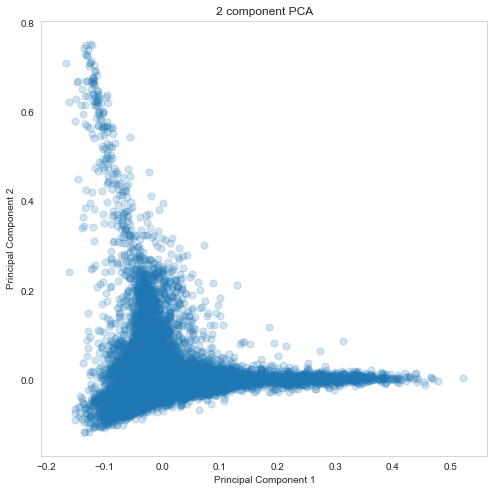

In [121]:
# Scatterplot of all feature's words
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component PCA', fontsize=12)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

#### 10 tags

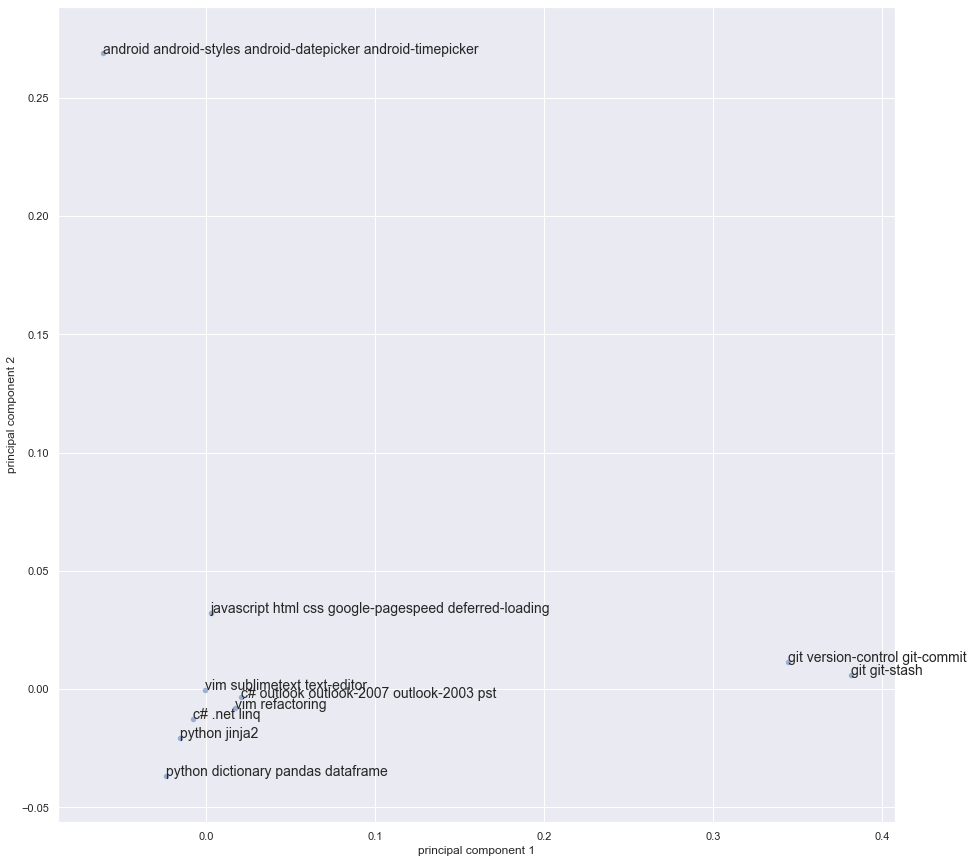

In [180]:
# Scatterplot with names of 50 most important features

liste_mots = list(y_train_clean[:10])

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (15, 15))
sns.scatterplot(principalDf['principal component 1'][:10],
           principalDf['principal component 2'][:10], alpha = 0.5)
 
for i in range(10):    
    
    plt.text(principalDf['principal component 1'][i], principalDf['principal component 2'][i], liste_mots[i],
         fontsize = 14)

plt.show()

### 6.3.2 t-SNE 

In [181]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)


In [ ]:
tsne_df = tsne.fit_transform(X_train_tfidf)

In [183]:
principalDf = pd.DataFrame(data=tsne_df, columns=[
                           'principal component 1', 'principal component 2'])

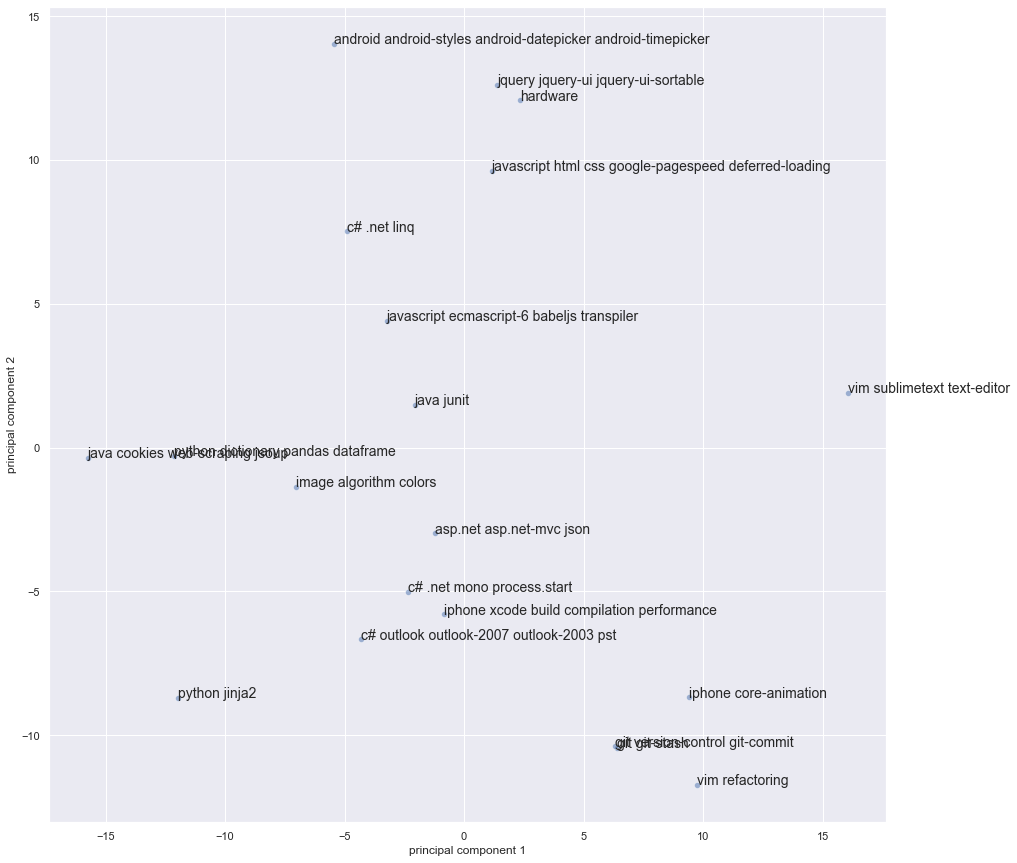

In [185]:
# Scatterplot with names of 50 most important features

liste_mots = list(y_train_clean[:20])

sns.set()# Initialize figure
fig, ax = plt.subplots(figsize = (15, 15))
sns.scatterplot(principalDf['principal component 1'][:20],
           principalDf['principal component 2'][:20], alpha = 0.5)
 
for i in range(20):    
    
    plt.text(principalDf['principal component 1'][i], principalDf['principal component 2'][i], liste_mots[i],
         fontsize = 14)

plt.show()